<a href="https://colab.research.google.com/github/blckpwdr50/datasciencecoursera/blob/master/TRAIN_HS_PD_Lecture_17_%5BDaniel_Schaben%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture 17: Q-Learning Demo**
---


### **Description**
This notebook demonstrates how to use Q-Learning for several games.

<br>

### **Structure**
* **Part 1**: [Gridworld](#p1)

* **Part 2**: [Frozen Lake](#p2)

<br>

**Run the code below to install and import all necessary libraries, functions, and datasets.**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython import display
import time

import gym

<a name="p1"></a>

---
## **Part 1: Gridworld**
---

<br>

### ***Read before implementing.***


Gridworld is a game in which a player aims to travel from the start position to the goal position in the fewest moves possible. We will explore the game ourselves first, understand how rewards are given, and build a reinforcement learning agent that learns to play the game. Here is an overview of the game:

<br>

### **The Goal**
**The goal of Gridworld is to get the red block (the player) to the blue block (the goal state) in the shortest distance possible.**

* The `Red` block represents the Agent.

* The `Blue` block represents the Goal State.

* `Grey` blocks represent obstructions.

<br>

### **Initializing the Game**

Running `new_game = Create_game()` will create a new instance of the game and store it in the variable `new_game`.

<br>

### **Important Components of the Game**

1. `new_game.running` will return `True` if the game is in progress or `False` if the game is over.


2. `new_game.start_pos` will give the starting position of the player.


3. `state, reward = new_game.move(action)` will move the player in the game and returns two values:
  `current_state` and `reward`.

  **There are 4 valid moves:**

  `0` Will move the player **North**.

  `1` Will move the player **East**.

  `2` Will move the player **South**.

  `3` Will move the player **West**.


4. `new_game.display()` draws a visual representation of the game.

  **There are 2 optional arguments you can pass into `.display`:**
    1. `new_game.display(show_reward=True)` shows the reward associated with landing at each positon on the grid.
    2. `new_game.display(Q=Qvalues)` - By passing in the Q values of your RL agent you can visualize what the strategy of the Agent at each point of the map.

<a name="p1.1"></a>

---
### **Part 1.1: Practice Together**
---

We will start by doing the following:

1. Load in the game
2. Familiarize ourselves with the game and the associated rules
3. Create and train the RL agent
4. Observe the Agent playing the game
5. Visualize the strategy of the Agent


#### **Step #1: Load the Game generator**

**Run the following code to load the game generator.**

<br>

**NOTE**: This game generator, which is mostly for drawing the game visualizations, is completed for you. You may look at the code inside it, *but do not edit it*.

In [ ]:
#@title Create_game() { display-mode: "form" }
class Create_game():
  def __init__(self):
    # Game is running
    self.running = True
    self.display_init = False
    self.display_update = False
    # self.display_clear = False

    # Create border for 12x12
    self.grid = (12,12)
    self.blocks = np.array([142, 143, 3, 35, 8, 135, 84, 120, 139, 36, 133, 4, 9, 131,
                   71, 132, 23, 141, 5, 48, 10, 0, 59, 137, 138, 140, 119, 6,
                   11, 60, 1, 96, 136, 12, 95, 7, 107, 134, 47, 2, 72, 108, 24, 83])

    # Add in goal, agent block
    self.goal_pos = 33
    self.start_pos = 75
    self.player_pos = 75

    # Create Reward Table
    self.rewards = np.ones((144)) * -1
    self.rewards[self.blocks] = -10
    self.rewards[self.goal_pos] = 50

  def display(self, show_rewards=False, Q=None):
    if self.display_init:
      self.ax.set_title("The Land of GridWorld")
      self.ax.axis('off')
      if show_rewards:
        for pos in range(len(self.rewards)):
            i, j = np.unravel_index(pos, self.grid, order="F")
            self.ax.text(i,j,self.rewards[pos],ha='center',va='center')
            self.display_init = False
      elif Q is not None:
        for pos in range(len(Q)):
          i, j = np.unravel_index(pos, self.grid, order="F")
          arrow_dict = {0:(0,0.4),1:(0.4,0),2:(0,-0.4),3:(-0.4,0)}
          dx, dy = arrow_dict[np.argmax(Q[pos,:])]
          self.ax.arrow(i, j , dx , dy , fc="k", ec="k", head_width=0.1, head_length=0.1)
        self.display_init = False
      temp_board = self.visual_board.copy()
      temp_board[self.player_pos] = (240, 15, 60)
      self.ax.imshow(temp_board.reshape(*self.grid,3), origin="lower")
      if self.display_update:
        self.hdisplay.update(self.fig)
      self.display_update = True

    else:
       # Prepare Rendering Engine
      self.hdisplay = display.display("12x12 Game Board", display_id=True)
      self.fig, self.ax = plt.subplots(figsize=(7,7))
      # Create Visual Board
      self.visual_board = np.array([(255,255,255) for _ in range(144)])
      self.visual_board[self.goal_pos] = (11, 218, 222)
      self.visual_board[self.blocks] = (120, 124, 125)
      self.display_init = True
      self.display_update = False
      self.display(show_rewards=show_rewards, Q=Q)

  def move(self, action):
    move_dict = {0:(1,0),1:(0,1),2:(-1,0),3:(0,-1)}
    # Convert action to a proposed new state in flat form
    cartesian_pos = np.unravel_index(self.player_pos, self.grid)
    move = move_dict[action]
    new_cartesian_pos = np.array(cartesian_pos) + np.array(move)
    new_pos = np.ravel_multi_index(new_cartesian_pos, self.grid)

    if new_pos == self.goal_pos:
      # Reached Goal State
      self.running = False
      self.player_pos = new_pos
    elif new_pos not in self.blocks:
      # Valid Move
      self.player_pos = new_pos

    return (self.player_pos, self.rewards[new_pos])

#### **Step #2 Play the game ourselves**

***This code is completed for you***

The Game can be played as a traditional user input game. Run this cell to open up an input box.

To move the player (the red square) around, input:
0. North (Up)
1. East (Right)
2. South (Down)
3. West (Left)

In [ ]:
# Run the game with Human Input

simple_grid = Create_game()

while simple_grid.running:
  simple_grid.display()
  simple_grid.move(int(input("Enter your move: ")))

We can show the rewards associated with each position by passing the argument `show_rewards=True` into the display function:

***Run the code below to view the rewards for each position on the map.***


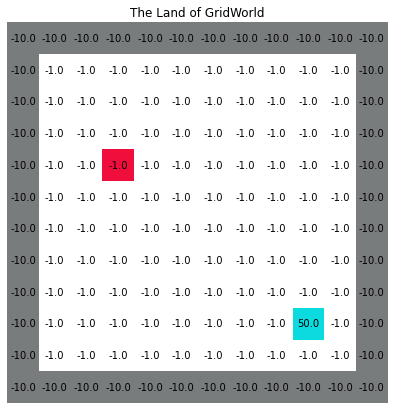

In [ ]:
simple_grid.display(show_rewards=True)

#### **Steps #3 - 4: Create the RL Agent**

In order to make the agent, you must create a **Q table** that is of the correct size (no. of states, no. actions).

Each column in our table represents taking a specific action. Therefore, column 0 represents action 0.
* If we have a 12 x 12 grid, there are **144 states**.
* If we can move `N`,`S`,`E`,`W` there are **4 actions**.

<br>

The general pseudocode is as follows:

```pseudocode
Create a Q table full of random numbers.

for episode in 100:
  Create a game
  Set the current_state equal to the starting game position
  while the game is running:
    Take the action which has the highest value for the current state
    Make a move in the game using that action and record the new_state and reward
    Update the Q table according to the Q function
    Update the current state to the new state
```

<br>

### **The Q function:**

$$
Q[S,A] = Q[S,A] + \alpha \{ reward + \gamma\max (Q[S_{new}]) - Q[S,A] \}
$$

For our purposes we will set the learning rate $\alpha$ `alpha = 0.5` and the discount factor $\gamma$ `gamma = 0.8`

<br>

### **Useful functions:**

**Generating a table of random numbers**
>The `np.random.rand(x,y)` will create a grid of random numbers with `x` rows and `y` columns.

**Getting the position of the max value of an arrar**
> The `np.argmax(array)` will return the (zero indexed) position of the max value. For example `np.argmax([2,4,1,9,7,5])` will return `3`.

In [ ]:
Q = np.random.rand(144,4)
alpha = 0.5
gamma = 0.8

for episode in range(100):
  game = Create_game()
  state = game.player_pos
  while game.running:

    # Choose an Action
    action = np.argmax(Q[state])

    # Make a move in the Game
    new_state, reward = game.move(action)

    # Update the Q table
    Q[state, action] += 0.5*(reward + 0.8*np.max(Q[new_state]) - Q[state,action])

    # Update the State
    state = new_state

#### **Step #5: Watch the Agent play the game - did it learn correctly?**

***This code is completed for you.***

To use the function, pass in the variable containing your Q values and the variable containing the game generator (here it is called `Create_game`).

In [ ]:
# Test your agent!
def test_agent(Q, Game):
  test_game = Game()
  state = test_game.player_pos

  while test_game.running:
    time.sleep(0.3)
    action = np.argmax(Q[state])
    state, _ = test_game.move(action)
    test_game.display()

  if state == test_game.goal_pos:
    print("Agent Reached the Goal!")

# Pass your Q value table into this function below
test_agent(Q, Create_game)

#### **Step \#6: Observe the strategy of the RL Agent.**

The code below will produce an arrow at each square in the gridworld representing which action has the highest value. That is to say, if you agent lands on a given square, the arrow shows where they will move next.

**Run the code below to look at where the arrows are pointing. Do you see a path to the goal?**

In [ ]:
# Visualise the Strategy of the Q learning Agent
s = Create_game()
s.display(Q=Q)

<a name="p1.2"></a>

---
### **Part 1.2: Gridworld level 2**
---

Now, we will be building a very similar RL agent as we did in Part 1, but this time **Gridworld** has obstacles in the map!

Just as we did in Part 1 we will do the following in Part 2:

1. Load in the new `game2`
2. Familiarize ourselves with the new game and the associated rules
3. Create and train the RL agent
4. Observe the Agent playing the game
5. Visualize the strategy of the Agent

#### **Step \#1: Load the Game generator**

**Run the following code to load the game generator.**

<br>

**NOTE**: This game generator, which is mostly for drawing the game visualizations, is completed for you. You may look at the code inside it, *but do not edit it*.

In [ ]:
#@title Create_game2 {display-mode: "form"}
class Create_game2(Create_game):
  def __init__(self):
    super().__init__()
    obstacles = [121, 22, 122, 14, 92, 3, 68, 88, 7, 89, 114, 45, 88, 74, 119]
    self.blocks = np.r_[self.blocks, obstacles]
    self.agent_pos = 87
    self.rewards = np.ones((144)) * -1
    self.rewards[self.blocks] = -10
    self.rewards[self.goal_pos] = 50

##### **Let's take a look at the new map**:


Hopefully you should be able to see some obstacles blocking the path to the Goal!

These obstacles are represented by grey blocks and the agent receives a penalty for trying to move into them.

In [ ]:
game2 = Create_game2()
game2.display()

#### **Steps \#2 - 4: Create the RL Agent**

**Complete this code using the same set of parameters that we used in Part 1.**

<br>

>**Knowledge check!**<br>
If we have a 12x12 grid, how many states would we have? <br>
If there are 4 possible moves, how many actions are there? <br>
Using these two, how big must our Q table be?


<br>

As a reminder, a Q table acts as the memory for the Q-learning agent. It stores a value associated with how rewarding a given action is at a given state.

*Useful equations and functions that were introduced earlier are repeated below for convenience:*

<br>

### **The Q function:**

$$
Q[S,A] = Q[S,A] + \alpha \{ reward + \gamma\max (Q[S]) - Q[S,A] \}
$$

For our purposes we will set the learning rate $\alpha$ `alpha=0.5` and the discount factor $\gamma$ `gamma=0.8`

<br>

### Useful functions:

**Generating a table of random numbers**
>The `np.random.rand(x,y)` will create a grid of random numbers with `x` rows and `y` columns.

**Getting the position of the max value of an arrar**
> The `np.argmax(array)` will return the (zero indexed) position of the max value. For example `np.argmax([2,4,1,9,7,5])` will return `3`.

In [ ]:
Q2 = np.random.rand(144,4)
alpha =  # COMPLETE THIS LINE
gamma =  # COMPLETE THIS LINE

for episode in range(# COMPLETE THIS LINE
  game2 = Create_game2()
  state = game2.agent_pos
  while game2.running:

    # Exploitation Step
    action = # COMPLETE THIS LINE

    # Make a move in the Game2
    new_state, reward = # COMPLETE THIS LINE

    # Update the Q2 table
    Q2[state, action] += # COMPLETE THIS LINE

    # Update the State
    state = # COMPLETE THIS LINE

##### **Solution**

In [ ]:
Q2 = np.random.rand(144,4)
alpha = 0.5
gamma = 0.8

for episode in range(100):
  game2 = Create_game2()
  state = game2.agent_pos
  while game2.running:

    # Exploitation Step
    action = np.argmax(Q[state])

    # Make a move in the Game2
    new_state, reward = game.move(action)

    # Update the Q2 table
    Q2[state, action] += alpha*(reward + gamma*np.max(Q[new_state])) - Q2[state, action]

    # Update the State
    state = new_state

#### **Step #5: Watch the Agent play the game - did it learn correctly?**

***This code is completed for you.***

We will use the same function as before, but we will pass in the variable containing our new Q values and the variable containing the game2 generator (here it is called `Create_game2`).

In [ ]:
# Test your agent!
def test_agent(Q, Game):
  test_game = Game()
  state = test_game.player_pos

  while test_game.running:
    time.sleep(0.3)
    action = np.argmax(Q[state])
    state, _ = test_game.move(action)
    test_game.display()

  if state == test_game.goal_pos:
    print("Agent Reached the Goal!")

# Pass your Q value table into this function below
test_agent(Q2, Create_game2)

#### **Step \#6: Observe the strategy of the RL Agent.**

***Run the code below to visualize the strategy of your agent.***

In [ ]:
# Visualise the Strategy of the Q learning Agent
s = Create_game()
s.display(Q=Q2)

### **Congratulations! You've just completed your first Reinforcement Learning algorithm.**


Some ways to explore this code further:
* Change the number of episodes that the RL agents are allowed to train.
* Change the parameters `alpha` and `gamma`.
* Attempt creating a new level by altering the hidden code for creating the game. Specifically, there is a list called `obstacles` that lists the position of each obstacle. Simply change the numbers in here to create or remove obstacles.

<a name="p2"></a>

---
## **Part 2: Frozen Lake**
---


The FrozenLake environment is a simple gridworld where the agent starts in the top-left corner and must navigate to the bottom-right corner while avoiding holes in the ice. The agent can move up, down, left, or right in each step.

#### **Step #1: Create the environment.**

In this case we are using the `FrozenLake` environment.


**Run the following code before continuing:**

In [ ]:
# Create the environment
env = gym.make('FrozenLake-v1')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


#### **Step #2: Set up hyperparameters.**


* `Learning rate` - a value between 0 and 1 that determines the step size at which the Q-table is updated in the algorithm.

* `Discount factor` - a value between 0 and 1 used to balance the trade-off between short-term and long-term rewards.

* `Number of episodes` - the number of times the agent will run through the environment and learn from its experiences.

<br>

**NOTE**: In this code, the learning rate is set to `0.8`, the discount factor is set to `0.95`, and the number of episodes is set to `2000`. However, they can be adjusted to see how it impacts the training process.

In [ ]:
# Hyperparameters
learning_rate = 0.8
discount_factor = 0.95
num_episodes = 2000

#### **Step #3: Initialize the Q-table.**


In [ ]:
# Initialize the Q-table
q_table = np.zeros((env.observation_space.n, env.action_space.n))


In [ ]:
# Visualize the Q-table
import matplotlib.pyplot as plt

def visualize_q_table(q_table):
    plt.imshow(q_table, cmap='hot', interpolation='nearest')
    plt.show()


#### **Step #5: The Q-Learning Algorithm.**

**Run the cell below to play the game. (*This may take a while to run.*)** While this runs, take a look at each step and try to determine what the code is doing.

<br>

The q-learning algorithm used in this code is a type of reinforcement learning algorithm that is used to train an agent to navigate through a given environment and make decisions based on the rewards it receives. The initialization above will be used to store the agent's knowledge of the environment. The agent then enters the environment and takes an action based on the current state. The agent's performance is evaluated by calculating the average reward per step.

**The goal is to train the agent to navigate through this environment and reach the goal with a high average reward per step.**


Episode: 0, Average Reward: 0.00


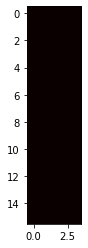

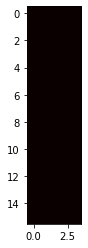

Episode: 100, Average Reward: 0.00


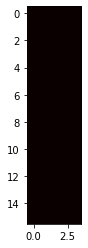

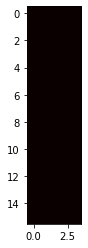

Episode: 200, Average Reward: 0.00


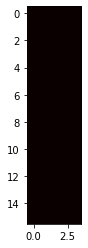

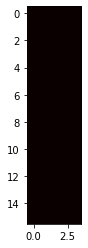

Episode: 300, Average Reward: 0.00


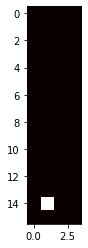

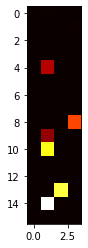

Episode: 400, Average Reward: 0.00


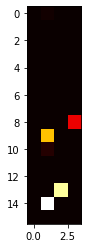

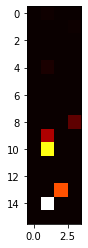

Episode: 500, Average Reward: 0.00


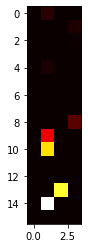

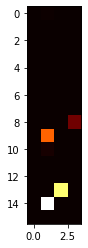

Episode: 600, Average Reward: 0.00


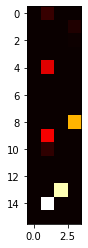

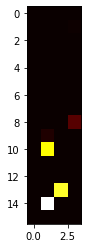

Episode: 700, Average Reward: 0.00


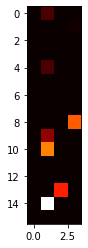

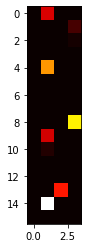

Episode: 800, Average Reward: 1.00


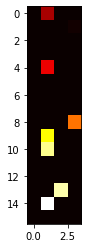

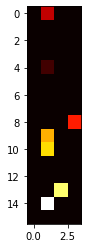

Episode: 900, Average Reward: 0.00


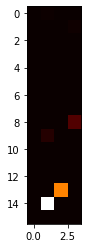

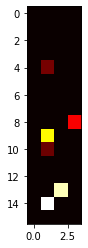

Episode: 1000, Average Reward: 0.00


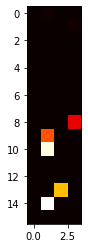

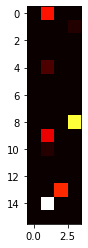

Episode: 1100, Average Reward: 0.00


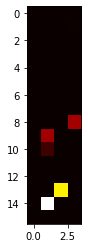

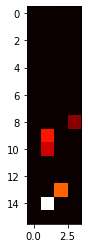

Episode: 1200, Average Reward: 0.00


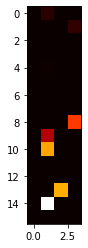

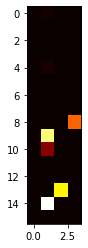

Episode: 1300, Average Reward: 0.00


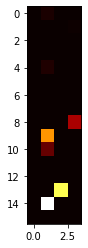

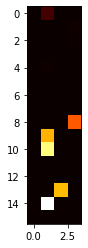

Episode: 1400, Average Reward: 0.00


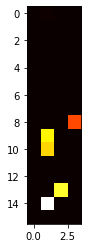

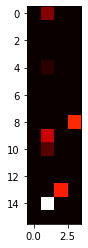

Episode: 1500, Average Reward: 0.00


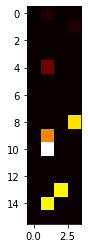

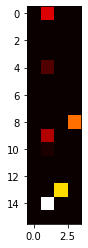

Episode: 1600, Average Reward: 0.00


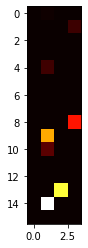

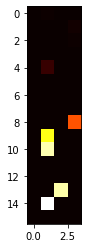

Episode: 1700, Average Reward: 0.00


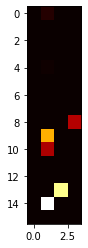

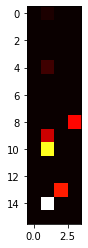

Episode: 1800, Average Reward: 0.00


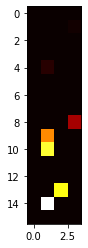

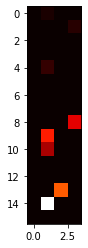

Episode: 1900, Average Reward: 0.00


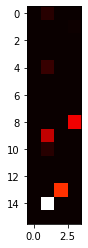

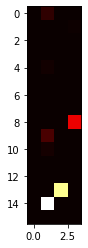

In [ ]:
for episode in range(num_episodes):
    # reset the environment
    env.reset()
    state = env.s
    episode_rewards = 0
    done = False

    while not done:
        # select the action with the highest Q-value
        if np.max(q_table[state]) > 0:
            action = np.argmax(q_table[state])
        # if there's no best action (only zeros), take a random one
        else:
            action = env.action_space.sample()

        # take the action and observe the outcome
        new_state, reward, done, _ = env.step(action)
        # update the Q-value for the current state-action pair
        q_table[state, action] = q_table[state, action] + learning_rate * (reward + discount_factor * np.max(q_table[new_state, :]) - q_table[state, action])
        episode_rewards += reward
        state = new_state

    if episode % 100 == 0:
        print('Episode: {}, Average Reward: {:.2f}'.format(episode, episode_rewards))
    if episode % 50 == 0:
        visualize_q_table(q_table)


#End of Notebook

---
© 2023 The Coding School, All rights reserved